In [18]:
!pip install captum

In [56]:
import torch            # PyTorch: 딥러닝 모델 구축 및 텐서 연산을 위한 핵심 라이브러리
import torch.nn as nn   # Neural Network 모듈: 레이어(Layer)와 모델을 정의하는 기능
import torch.nn.functional as F # 자주 사용되는 함수 모음 (활성화 함수, 손실 함수 등)
import torch.optim as optim # 옵티마이저(Optimizer) 모듈: 모델 파라미터 학습을 위한 기능
from torch.utils.data import DataLoader # 데이터 로딩 및 배치 처리를 위한 유틸리티
from torchvision import datasets, transforms # 이미지 데이터셋과 데이터 전처리(변환) 기능

import matplotlib.pyplot as plt # 데이터 시각화 (그래프, 이미지 출력)
import numpy as np              # 과학 계산 및 다차원 배열 처리 (NumPy)

# --- Captum (모델 설명 가능성, XAI) 라이브러리 임포트 ---
from captum.attr import IntegratedGradients # 통합 그래디언트(Integrated Gradients) 기법 임포트
from captum.attr import Saliency        # 살리언시 맵(Saliency) 기법 임포트
from captum.attr import DeepLift        # DeepLIFT 기법 임포트
from captum.attr import visualization as viz # 어트리뷰션 결과 시각화를 위한 유틸리티 임포트

In [57]:
np.random.seed(123)
torch.manual_seed(123)

모델 아키텍처 정의

In [58]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # 첫 번째 합성곱 레이어: 입력 채널 1개 (흑백 이미지), 출력 채널 16개, 커널 크기 3x3, 스트라이드 1
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        # 두 번째 합성곱 레이어: 입력 채널 16개, 출력 채널 32개, 커널 크기 3x3, 스트라이드 1
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        # 첫 번째 드롭아웃: 합성곱 레이어 이후 과적합 방지를 위해 10%의 뉴런을 무작위로 제거
        self.dp1 = nn.Dropout2d(0.10)
        # 두 번째 드롭아웃: 완전 연결 레이어 이후 25%의 뉴런을 무작위로 제거
        self.dp2 = nn.Dropout2d(0.25)
        # 첫 번째 완전 연결 레이어: 4608개의 입력 노드를 64개의 출력 노드로 연결
        # 4608 = (풀링 후 이미지 크기 12x12) * (채널 수 32)
        self.fc1 = nn.Linear(4608, 64)
        # 두 번째 완전 연결 레이어 (출력 레이어): 64개의 입력 노드를 10개의 출력 노드로 연결 (10개의 클래스)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # 첫 번째 Conv 레이어 통과
        x = self.cn1(x)
        # ReLU 활성화 함수 적용
        x = F.relu(x)
        # 두 번째 Conv 레이어 통과
        x = self.cn2(x)
        # ReLU 활성화 함수 적용
        x = F.relu(x)
        # 최대 풀링 (Max Pooling): 커널 크기 2x2로 크기를 절반으로 줄임
        x = F.max_pool2d(x, 2)
        # 첫 번째 드롭아웃 적용
        # 드랍아웃은 일반적으로 합성곱 레이어 이후에 적용
        x = self.dp1(x)
        # 배치(Batch) 차원을 제외하고 나머지 차원(채널, 높이, 너비)을 평탄화하여 1차원 벡터로 만듦
        x = torch.flatten(x, 1)
        # 첫 번째 완전 연결 레이어 통과
        x = self.fc1(x)
        # ReLU 활성화 함수 적용
        x = F.relu(x)
        # 두 번째 드롭아웃 적용
        x = self.dp2(x)
        # 최종 완전 연결 레이어 통과
        x = self.fc2(x)
        # 로그 소프트맥스(Log Softmax) 적용: 최종 클래스 확률 분포를 로그 형태로 출력
        op = F.log_softmax(x, dim=1)
        return op
        # 로그 소프트맥스로 만들어줌
        # >> 최종출력 : 클래스(class) 별로 로그 확률 분포
        # 왜? 로그를 쓰면 일반적으로 수치가 안정됨
        # (소프트맥스 함수가 가진 지수함수 e가 컴퓨터가 표현하지 못하는 범위를 넘는 오버플로우 방지)

In [59]:
def train(model, device, train_dataloader, optim, epoch):
    # 모델을 훈련 모드(training mode)로 설정합니다.
    # 드롭아웃(Dropout)이나 배치 정규화(BatchNorm)와 같은 레이어가 훈련 시에만 작동하도록 활성화됩니다.
    model.train()

    # DataLoader를 순회하며 배치 단위(**)로 데이터(X: 입력, y: 정답 레이블)를 가져옵니다.
    for b_i, (X, y) in enumerate(train_dataloader):
        # 입력 데이터와 정답 레이블을 설정된 장치(GPU 또는 CPU)로 이동시킵니다.
        X, y = X.to(device), y.to(device)

        # 옵티마이저의 누적된 기울기(gradient)를 0으로 초기화합니다.
        optim.zero_grad()

        # 입력 데이터를 모델에 넣어 예측 확률(로그 확률)을 계산합니다. (순전파, Forward pass)
        pred_prob = model(X)

        # 손실 함수(Loss function)로 Negative Log-Likelihood Loss (음의 로그 우도 손실)를 계산합니다.
        # F.nll_loss는 주로 모델의 최종 출력이 F.log_softmax일 때 사용됩니다.
        loss = F.nll_loss(pred_prob, y) # nll is the negative likelihood loss
        # NLLLoss(Log_softmax(x), target) == CrossEntropy(Softmax(x), target)
        # >> 수치적 안정됨

        # 역전파(Backward pass): 손실을 기준으로 모델 파라미터들의 기울기를 계산합니다.
        loss.backward()

        # 옵티마이저를 사용하여 계산된 기울기를 바탕으로 모델의 파라미터(가중치)를 업데이트합니다.
        optim.step()

        # 10개 배치(batch)마다 학습 진행 상황을 출력합니다.
        if b_i % 10 == 0:
            print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                epoch, b_i * len(X), len(train_dataloader.dataset), # 현재 처리된 데이터 개수와 전체 데이터 개수
                100. * b_i / len(train_dataloader), loss.item())) # 전체 데이터 대비 현재 진행률과 현재 배치 손실

NNLLoss

- likelihood : 발생가능성
  - 모델이 주어진 입력에 대해 정답레이블을 정확하게 예측할 확률 (MLE 최대우도법)
- log-likelihood : 수치 안정성을 위해 사용함(확률의 단점 보완)
- Negative Log Likihood (음의 로그 우도)
  - 모델을 훈련시키는 목적 : (y-y_hat) 손실 (loss) 최소화
  - 모델이 정답을 잘 맞추네 >> 우도가 높네 (1에 가까워짐)
  - 우도가 높으면 >> 로그 우도 log 1 = 0 에 가까운 큰 음수 또는 0에 가까운 양수
  - 결론적으로 로그 우도를 최대화 하는 것 대신에
  - 로그 우도에 음수(-) 취한 음의 로그우도(NLL) 를 최소화하는 방식으로 모델 학습 시킴

Cross Entropy 와 nn.NLLLoss() 비교
- logits / log prob (log softmax 적용한 후)
- log_softmax >> NLLLoss / Log softmax 적용 안해도 NLLLoss 만 계산 가능
- 간편(한 번 호출로 끝) / 수치적 안정성 높고, 로그 소프트 맥스 과정(단계별) 을 분리해서 볼 수 있음
- CrossEntropy = log-softmax + NLLLoss

In [60]:
def test(model, device, test_dataloader):
    # 모델을 평가 모드(evaluation mode)로 설정합니다.
    # 드롭아웃(Dropout)이나 배치 정규화(BatchNorm)와 같은 레이어가 비활성화되어 일관된 예측을 수행합니다.
    model.eval()

    loss = 0 # 전체 테스트 데이터셋의 총 손실을 누적할 변수
    success = 0 # 올바르게 분류된 샘플의 총 개수 (정답 수)

    # 기울기 계산을 일시적으로 비활성화합니다.
    # 메모리 사용량을 줄이고 계산 속도를 높이며, 테스트 단계에서는 역전파가 필요 없기 때문입니다.
    with torch.no_grad():
        # 테스트 DataLoader를 순회하며 배치 단위로 데이터를 가져옵니다.
        for X, y in test_dataloader:
            # 입력 데이터와 정답 레이블을 설정된 장치(GPU 또는 CPU)로 이동시킵니다.
            X, y = X.to(device), y.to(device)

            # 순전파: 모델에 데이터를 넣어 예측 확률(로그 확률)을 계산합니다.
            pred_prob = model(X)

            # 배치별 손실을 계산하고 전체 손실에 누적합니다.
            # (reduction='sum'으로 배치 내 손실 합산)
            loss += F.nll_loss(pred_prob, y, reduction='sum').item()  # loss summed across the batch

            # 예측 확률이 가장 높은 클래스 인덱스(dim=1 기)를 최종 예측(pred)으로 선택합니다.
            pred = pred_prob.argmax(dim=1, keepdim=True)  # us argmax to get the most likely prediction

            # 예측(pred)과 정답 레이블(y)을 비교하여 맞은 개수를 세어 success에 누적합니다.
            # pred.eq(y.view_as(pred))는 참/거짓 텐서를 반환하며, .sum().item()으로 참의 개수를 셉니다.
            # y.view_as(pred) : y(정답 레이블) 텐서 형태를 pred 텐서 형태와 동일(batch_size,1) 변경
            success += pred.eq(y.view_as(pred)).sum().item()

    # 전체 손실을 전체 데이터셋 크기로 나누어 평균 손실을 계산합니다.
    loss /= len(test_dataloader.dataset)

    # 테스트 결과 (평균 손실과 정확도)를 보기 좋게 출력합니다.
    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, success, len(test_dataloader.dataset), # 전체 데이터셋 크기와 정답 수
        100. * success / len(test_dataloader.dataset))) # 최종 정확도 (%)

In [61]:
# The mean and standard deviation values are calculated as the mean of all pixel values of all images in the training dataset
# --- 훈련 데이터셋 로더 정의 ---
train_dataloader = torch.utils.data.DataLoader(
    # MNIST 데이터셋 로드: 'train=True'로 설정하여 훈련 데이터 사용
    datasets.MNIST('../data', train=True, download=True,
                   # 데이터 전처리 파이프라인 (Compose) 정의
                   transform=transforms.Compose([
                       # 1. ToTensor(): 이미지를 PyTorch Tensor로 변환하고 픽셀 값을 [0, 1] 범위로 자동 스케일링
                       transforms.ToTensor(),
                       # 2. Normalize(): 훈련 데이터셋의 평균(0.1302)과 표준편차(0.3069)를 사용하여 정규화
                       # 이는 각 픽셀 값을 (value - mean) / std 로 변환하여 데이터 분포를 표준 정규 분포에 가깝게 만듭니다.
                       transforms.Normalize((0.1302,), (0.3069,))])), # train_X.mean()/256. and train_X.std()/256.
    # 배치 크기(Batch Size)를 32로 설정
    batch_size=32,
    # 데이터를 매 에포크마다 무작위로 섞어서(셔플) 모델의 학습 안정성을 높입니다.
    shuffle=True)

# --- 테스트 데이터셋 로더 정의 ---
test_dataloader = torch.utils.data.DataLoader(
    # MNIST 데이터셋 로드: 'train=False'로 설정하여 테스트 데이터 사용
    datasets.MNIST('../data', train=False,
                   # 테스트 데이터셋에도 훈련 데이터셋과 동일한 전처리(정규화)를 적용
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,))
                   ])),
    # 배치 크기를 500으로 설정 (테스트는 훈련보다 큰 배치 크기를 사용하는 경우가 많습니다.)
    batch_size=500,
    # 테스트 데이터도 셔플합니다. (평가 자체에는 필수적이지 않지만, 일관성 유지)
    shuffle=True)

In [62]:
torch.manual_seed(0)
device = torch.device("cpu")

model = ConvNet()
optimizer = optim.Adadelta(model.parameters(), lr=0.5)

- SGD:        무조건 일정한 보폭으로 내려감 (경사가 급해도, 완만해도)
- Adadelta:   경사에 따라 보폭 조절
            - 급한 경사: 작은 보폭 (안전하게)
            - 완만한 경사: 큰 보폭 (빠르게)

In [63]:
for epoch in range(1, 2):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:1531: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [0/60000 (0%)]	 training loss: 2.301478
epoch: 1 [320/60000 (1%)]	 training loss: 1.744135
epoch: 1 [640/60000 (1%)]	 training loss: 1.240407
epoch: 1 [960/60000 (2%)]	 training loss: 0.842911
epoch: 1 [1280/60000 (2%)]	 training loss: 0.949036
epoch: 1 [1600/60000 (3%)]	 training loss: 0.558535
epoch: 1 [1920/60000 (3%)]	 training loss: 0.620267
epoch: 1 [2240/60000 (4%)]	 training loss: 0.507514
epoch: 1 [2560/60000 (4%)]	 training loss: 0.467614
epoch: 1 [2880/60000 (5%)]	 training loss: 0.333481
epoch: 1 [3200/60000 (5%)]	 training loss: 0.370461
epoch: 1 [3520/60000 (6%)]	 training loss: 0.360044
epoch: 1 [3840/60000 (6%)]	 training loss: 0.329611
epoch: 1 [4160/60000 (7%)]	 training loss: 0.454153
epoch: 1 [4480/60000 (7%)]	 training loss: 0.382753
epoch: 1 [4800/60000 (8%)]	 training loss: 0.464870
epoch: 1 [5120/60000 (9%)]	 training loss: 0.209107
epoch: 1 [5440/60000 (9%)]	 training loss: 0.315105
epoch: 1 [5760/60000 (10%)]	 training loss: 0.133864
epoch: 1 [6080/60

In [64]:
test_samples = enumerate(test_dataloader)
# print([b_i for b_i in test_samples])

In [65]:
b_i, (sample_data, sample_targets) = next(test_samples)
print(b_i, sample_data.shape, sample_targets.shape)
# torch.Size([500, 1, 28, 28]) (batch_size, c, h, w)

0 torch.Size([500, 1, 28, 28]) torch.Size([500])


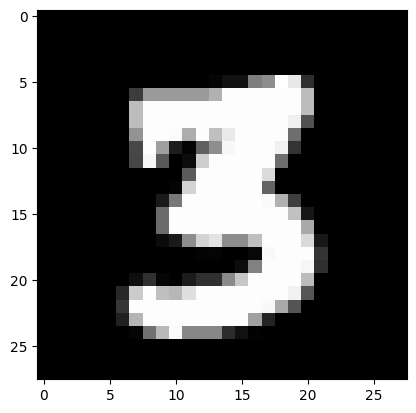

In [66]:
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)

plt.imshow(sample_data[0][0], cmap='gray', interpolation='none')
# sample data의 첫번째 이미지의 채널(c) 0 (흑백)을 보간법은 none으로서 원래 픽셀(px) 모양 유
plt.show()

In [67]:
sample_data[0].shape

torch.Size([1, 28, 28])

In [68]:
sample_data[0][0].shape

torch.Size([28, 28])

In [69]:
model(sample_data) # 예측값(확률값)
model(sample_data).shape
# ([500, 10]) (batch_size, 10)

torch.Size([500, 10])

In [70]:
model(sample_data).data.max(1) # 1 : dim=1 두번째 차원(클래스 차원) 기준 최대값 찾기
# (최대값 텐서, 최대값 인덱스 텐서)
model(sample_data).data.max(1)[1] # 최대값 인덱스 텐서
model(sample_data).data.max(1)[1].shape # torch.Size([500]) batch_size
model(sample_data).data.max(1)[1][0] # tensor(1) 첫번째 이미지에 대한 예측 인덱스

tensor(3)

In [71]:
print(f"Model prediction is : {model(sample_data).data.max(1)[1][0]}")
print(f"Ground truth is : {sample_targets[0]}")

Model prediction is : 3
Ground truth is : 3


captum tool

In [72]:
sample_data[0].unsqueeze(0) # batch 차원 증가

tensor([[[[-4.2424e-01, -4.2424e-01, -4.2424e-01, -4.2424e-01, -4.2424e-01,
           -4.2424e-01, -4.2424e-01, -4.2424e-01, -4.2424e-01, -4.2424e-01,
           -4.2424e-01, -4.2424e-01, -4.2424e-01, -4.2424e-01, -4.2424e-01,
           -4.2424e-01, -4.2424e-01, -4.2424e-01, -4.2424e-01, -4.2424e-01,
           -4.2424e-01, -4.2424e-01, -4.2424e-01, -4.2424e-01, -4.2424e-01,
           -4.2424e-01, -4.2424e-01, -4.2424e-01],
          [-4.2424e-01, -4.2424e-01, -4.2424e-01, -4.2424e-01, -4.2424e-01,
           -4.2424e-01, -4.2424e-01, -4.2424e-01, -4.2424e-01, -4.2424e-01,
           -4.2424e-01, -4.2424e-01, -4.2424e-01, -4.2424e-01, -4.2424e-01,
           -4.2424e-01, -4.2424e-01, -4.2424e-01, -4.2424e-01, -4.2424e-01,
           -4.2424e-01, -4.2424e-01, -4.2424e-01, -4.2424e-01, -4.2424e-01,
           -4.2424e-01, -4.2424e-01, -4.2424e-01],
          [-4.2424e-01, -4.2424e-01, -4.2424e-01, -4.2424e-01, -4.2424e-01,
           -4.2424e-01, -4.2424e-01, -4.2424e-01, -4.2424e-01,

In [73]:
captum_input = sample_data[0].unsqueeze(0)
captum_input.requires_grad = True
# batch 차원 증가
# 왜? captum 은 배치 형태의 입력 요
# requires_grad = True
# >> 기울기 계산 활성화
# >> 왜? XAI는 기울기(gradient) 사용 >> 각 pixel 의 중요도 계산

In [74]:
# --- 원본 이미지 준비 및 전처리 ---
# sample_data[0]: DataLoader에서 얻은 첫 번째 샘플 (텐서 형태)
# .cpu().detach().numpy(): PyTorch 텐서를 NumPy 배열로 변환 (GPU에서 CPU로 이동하고 기울기 계산 그래프에서 분리)
# / 2) + 0.5: 데이터 로더에서 적용된 정규화(Normalize)를 역으로 되돌리는 근사적인 역변환
#           (MNIST 정규화 값(0.1302, 0.3069)의 평균이 약 0.22인데, 이 코드는 간단히 [-1, 1] 범위로 가정하고 역변환)
# np.transpose(..., (1, 2, 0)): PyTorch 텐서의 채널 순서 (C, H, W)를 Matplotlib/NumPy 이미지 형식 (H, W, C)로 변경
tmp_image = np.transpose((sample_data[0].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

# np.tile(..., (1, 1, 3)): 단일 채널(흑백) 이미지를 RGB 3채널로 복제하여 만듭니다.
# ConvNet 모델이 1채널을 입력받았지만, 시각화는 보통 3채널 RGB 형식에서 더 잘 처리됩니다.
orig_image = np.tile(tmp_image, (1,1,3))
# Camtum 시각화 함수  rgb 기대
# >> MNIST(흑백, 1채널) >> 3채널 (복제)

# np.tile 역할
# [픽셀값] >> [픽셀값, 픽셀값, 픽셀값]
# 차원 축(0,1,2) 따라서 반복할 횟수 지정
# 같은 값 R,G,B  복사
# (1,1,3)
# 0번축 1 : 첫번째 차원(h: 높이) 1번만 반복(높이 변화 없어요)
# 1번축 1 : 두번째 차원(w: 너비) 1번만 반복(높이 변화 없어요)
# 2번축 3 : 세번째 차원(c: 채널) 3번 반복(채널 변화 있어요)
# 변환전 (hwc) (28,28,1) >> (28,28,3)

Sailiency Map(**)

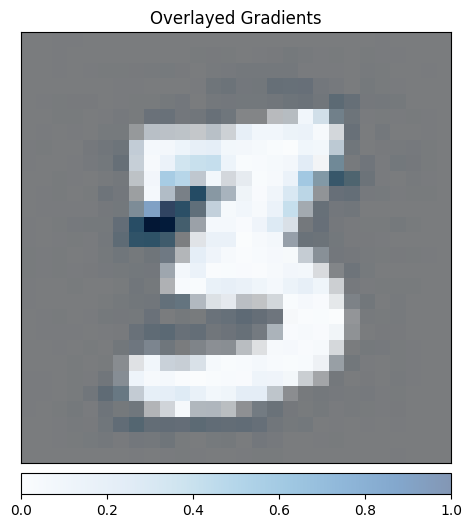

In [75]:
saliency = Saliency(model)
# Saliency 객체 생성: 모델(ConvNet)의 입력 대비 출력 기울기를 계산하는 도구 정의
gradients = saliency.attribute(captum_input, target=sample_targets[0].item())
# Saliency 계산 (어트리뷰션)
# .attribute(): 입력(captum_input)에 대해 타겟 클래스(target) 예측에 대한 기울기를 계산
# target=sample_targets[0].item(): 모델이 예측한 클래스(정답)를 타겟으로 설정하여,
#                                  모델이 왜 그 클래스를 예측했는지에 대한 중요도를 찾습니다.
gradients = gradients.squeeze().cpu().detach().numpy() # 텐서 > 넘파이

gradients = np.reshape(gradients, (28,28,1))

_ = viz.visualize_image_attr(gradients, orig_image, method="blended_heat_map", sign="absolute_value",
                             show_colorbar=True, title="Overlayed Gradients")

# --- 시각화 ---
# viz.visualize_image_attr(): Captum의 시각화 함수
# gradients: 어트리뷰션 결과 (각 픽셀의 중요도)
# orig_image: 원본 이미지 (배경으로 사용)
# method="blended_heat_map": 어트리뷰션 맵(히트맵)과 원본 이미지를 겹쳐서 시각화
# sign="absolute_value": 양의 기여도와 음의 기여도 구분 없이 기울기의 '절대값'을 중요도로 사용하여 시각화
# show_colorbar=True: 중요도 스케일을 표시하는 컬러 바를 출력

In [77]:
gradients

array([[[3.22341940e-08],
        [1.92529612e-07],
        [1.06076368e-06],
        [1.01009914e-06],
        [3.87335319e-08],
        [5.35363824e-07],
        [2.79596549e-07],
        [1.32936250e-07],
        [3.73686078e-08],
        [1.46518815e-08],
        [2.65517258e-07],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [3.91937334e-07],
        [5.03910201e-07],
        [7.37275741e-07],
        [4.09297485e-07],
        [7.79925017e-07],
        [1.13160263e-06],
        [6.86700901e-08],
        [1.74511413e-07],
        [4.35333078e-07],
        [0.00000000e+00]],

       [[3.74173226e-08],
        [3.79675726e-07],
        [1.59644276e-06],
        [7.77119681e-07],
        [1.05287626e-07],
        [4.73777561e-07],
        [8.42758368e-07],
        [8.96041144e-08],
        [1.85048833e-07],
        [4.51839497e-07],
        [2

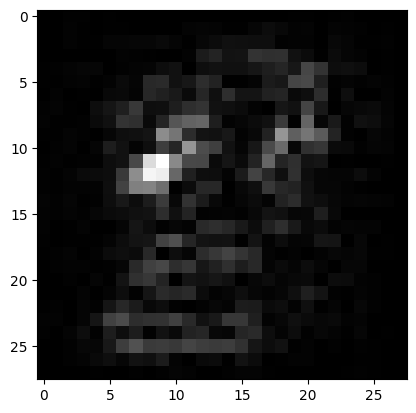

In [76]:
plt.imshow(np.tile(gradients/np.max(gradients), (1,1,3)));
# np.max(gradients) gradients 배열 내에서 최대값

Integrated Gradients

1. 단계 1: 경로 정의
   - 경로 a = 0 (검은 이미지) 아무런 정보가 없는 시작점(흑백)
   - 경로 a = 1 (원본 이미지)
   - 경로 a = 0.5 둘의 중간 (반 투명 이미지) (컬러: 평균)

2. 단계 2: 경로를 따라서 기울기 계산
   - 각 a 값에서 모델의 기울기 d(F) / d(x_i) 계산

3. 단계 3: 적분(모든 기울기를 합친다)
   - 수치적으로 리만 합으로 근사
   - 현실적으로 적분 안됨 (m개 점을 샘플링, m=50~300)

4. 단계 4: 입력 차이 곱하기
   - (x_i - x'_i) : 해당 픽셀이 기준점에서 얼마나 변했나


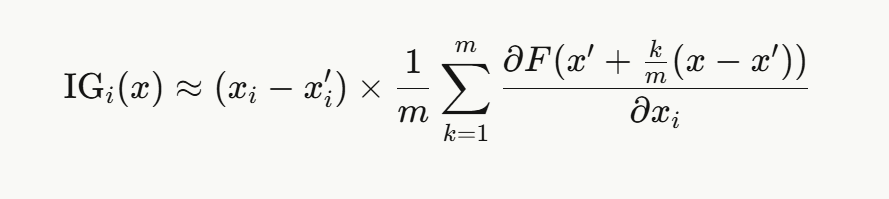

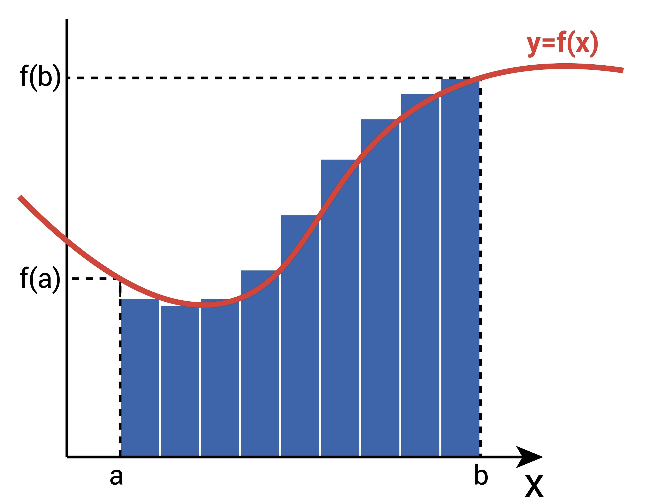

- 리만 합: 직사각형의 넓이의 합 >> 적분에 근사하게 기본 도구

/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:1531: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


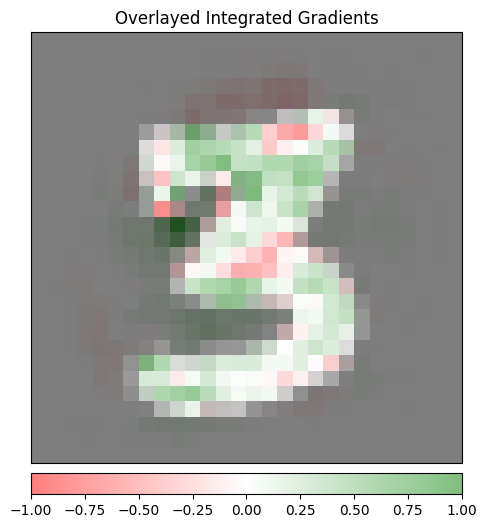

In [78]:
integ_grads = IntegratedGradients(model)
# IntegratedGradients 객체 생성: 모델(ConvNet)에 대한 통합 그래디언트 계산 도구 정의

# --- 통합 그래디언트(IG) 계산 ---
attributed_ig, delta = integ_grads.attribute(
    captum_input,                      # 분석할 입력 데이터
    target=sample_targets[0].item(),   # 타겟 클래스 인덱스 (모델이 예측한 클래스)
    baselines=captum_input * 0,        # 기준선(Baseline) 설정: 모든 픽셀 값을 0으로 설정한 이미지 (흑백 이미지의 경우 일반적)
    return_convergence_delta=True      # 수렴 델타 값 (오차)을 반환하도록 설정 (IG의 품질 확인 용도)
)

# --- 결과 후처리 및 시각화 준비 ---
# .squeeze().cpu().detach().numpy(): PyTorch 텐서를 NumPy 배열로 변환하고 불필요한 차원 제거
attributed_ig = attributed_ig.squeeze().cpu().detach().numpy()
# np.reshape(..., (28, 28, 1)): (H, W, C) 형식에 맞게 28x28x1 형태로 재구성 (시각화 준비)
attributed_ig = np.reshape(attributed_ig, (28, 28, 1))

# --- 시각화 ---
# viz.visualize_image_attr(): Captum의 시각화 함수
# attributed_ig: IG 어트리뷰션 결과 (각 픽셀의 통합된 중요도)
# orig_image: 원본 이미지 (배경으로 사용)
# method="blended_heat_map": 어트리뷰션 맵과 원본 이미지를 겹쳐서 시각화
# sign="all": 양의 기여도(긍정적 영향)와 음의 기여도(부정적 영향)를 모두 다른 색상으로 표시
# show_colorbar=True: 중요도 스케일을 표시하는 컬러 바를 출력
_ = viz.visualize_image_attr(attributed_ig, orig_image, method="blended_heat_map",sign="all", show_colorbar=True,
                             title="Overlayed Integrated Gradients")

DeepLift(model)
- 출력(target) 의 변화량을 입력의 변화량으로 분해 (체인룰)
- 기여도 : 활성화 변화량, 입력 변화량으로 결정

- 회사 매출 100억 >> 200억 증가
  - 영업       50억 기여 (50%)
  - 마케팅팀   30억 기여 (30%)
  - 개발팀     20억 기여 (20%)

- 이미지 관점에 보면
  - pixel a : 출력 증가하는 데 0.3 기여
  - pixel b : 출력 증가하는 데 0.2 기여
  - pixel c : 출력 증가하는 데 -0.1 기여 (부정적 영향)


/usr/local/lib/python3.12/dist-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:1531: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


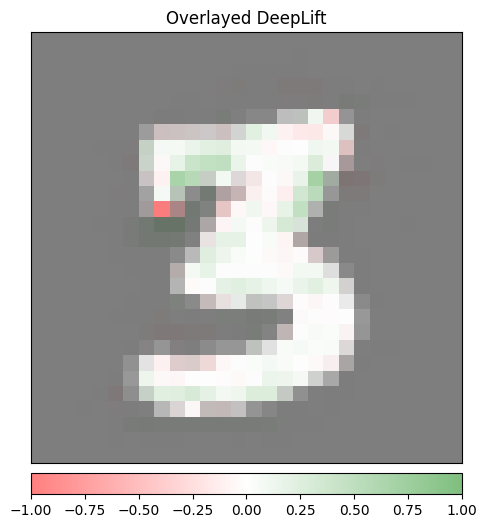

In [79]:
deep_lift = DeepLift(model) # DeepLIFT 객체 생성: 모델(ConvNet)에 대한 DeepLIFT 계산 도구 정의

# --- DeepLIFT 계산 ---
attributed_dl = deep_lift.attribute(
    captum_input,                      # 분석할 입력 데이터
    target=sample_targets[0].item(),   # 타겟 클래스 인덱스
    baselines=captum_input * 0,        # 기준선(Baseline) 설정: 모든 픽셀 값을 0으로 설정한 이미지
    return_convergence_delta=False     # 수렴 델타 값(오차) 반환을 비활성화
)

# --- 결과 후처리 및 시각화 준비 ---
# .squeeze(0): 첫 번째 배치(Batch) 차원만 제거합니다. (Captum 출력 형식에 따라 필요할 수 있음)
# .cpu().detach().numpy(): PyTorch 텐서를 NumPy 배열로 변환
attributed_dl = attributed_dl.squeeze(0).cpu().detach().numpy()
# np.reshape(..., (28, 28, 1)): (H, W, C) 형식에 맞게 28x28x1 형태로 재구성 (시각화 준비)
attributed_dl = np.reshape(attributed_dl, (28, 28, 1))

# --- 시각화 ---
# viz.visualize_image_attr(): Captum의 시각화 함수
# attributed_dl: DeepLIFT 어트리뷰션 결과 (각 픽셀의 기여도)
# orig_image: 원본 이미지 (배경)
# method="blended_heat_map": 어트리뷰션 맵과 원본 이미지를 겹쳐서 시각화
# sign="all": 양의 기여도(타겟 예측에 긍정적)와 음의 기여도(부정적)를 모두 표시
# show_colorbar=True: 중요도 스케일을 표시하는 컬러 바 출력
_ = viz.visualize_image_attr(attributed_dl, orig_image, method="blended_heat_map",sign="all",show_colorbar=True,
                             title="Overlayed DeepLift")

요약 정리

- 통합그래디언트(IG)는 0(가상의 기준선 baseline) 에서 원본이미지(input 실제 입력) 까지의 가상의 경로(path) 따라서 모델의 예측 변화 분석, 수치화

- 1) 0에서 시작(기준선) baseline 아무 정보도 없는 상태
- 2) 조금씩 밝히기 (경로 이동)    
  - 여기서 경로이동이란 예측값 변화(target) 에 대한 기울기(gradient) 계산
- 3) 영향력 누적(적분 >> 수치화)
  - 경로를 따라 계산된 모든 기울기 값 누적(적분) (리만 합)
  - 즉, 각 픽셀이 기준선(0) 에서 실제 이미지로 변하는 데 있어 총체적으로 얼마나 기여했나 수치화